In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D,
    Dense, Dropout, BatchNormalization, LayerNormalization,
    Input, Add, LeakyReLU, SpatialDropout1D, Concatenate
)
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers, losses
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# Load data
save_dir = "/content/drive/MyDrive/mitbih_processed_splits"

train_data = np.load(os.path.join(save_dir, "train_set.npz"))
val_data   = np.load(os.path.join(save_dir, "val_set.npz"))
test_data  = np.load(os.path.join(save_dir, "test_set.npz"))

X_train, y_train = train_data["X"], train_data["y"]
X_val,   y_val   = val_data["X"],   val_data["y"]
X_test,  y_test  = test_data["X"],  test_data["y"]

# Label encoding
label_mapping = {'N':0, 'S':1, 'V':2, 'F':3, 'Q':4}
y_train = np.array([label_mapping[l] for l in y_train])
y_val   = np.array([label_mapping[l] for l in y_val])
y_test  = np.array([label_mapping[l] for l in y_test])

num_classes = 5
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat   = to_categorical(y_val, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

# Reshape για CNN (samples, timesteps, channels)
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn   = X_val[..., np.newaxis]
X_test_cnn  = X_test[..., np.newaxis]

print("CNN input shape:", X_train_cnn.shape)

CNN input shape: (38572, 360, 1)


##**Using R-peak segments**

###**CNN 1D**

In [19]:
# Improved 1D CNN Architecture
inp = Input(shape=(360,1))

# Block 1
x = Conv1D(64, kernel_size=7, padding='same')(inp)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling1D(pool_size=2)(x)
x = SpatialDropout1D(0.1)(x)

# Block 2 (residual)
res = Conv1D(128, kernel_size=5, padding='same', activation='relu')(x)
res = BatchNormalization()(res)
res = Conv1D(128, kernel_size=5, padding='same')(res)
res = BatchNormalization()(res)
res = Add()([Conv1D(128, 1, padding='same')(x), res])
res = LeakyReLU(alpha=0.1)(res)
x = MaxPooling1D(pool_size=2)(res)
x = SpatialDropout1D(0.2)(x)

# Block 3
x = Conv1D(256, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling1D(pool_size=2)(x)
x = SpatialDropout1D(0.3)(x)

# Global Pooling (both average & max)
gap = GlobalAveragePooling1D()(x)
gmp = GlobalMaxPooling1D()(x)
x = Concatenate()([gap, gmp])  # richer feature representation

# Dense Head
x = Dense(128, activation='relu')(x)
x = LayerNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

out = Dense(num_classes, activation='softmax')(x)

model_cnn = Model(inp, out)
model_cnn.summary()

# Compile
opt = optimizers.Adam(learning_rate=0.001)
model_cnn.compile(
    optimizer=opt,
    loss=losses.categorical_crossentropy,
    metrics=['accuracy']
)

# Callbacks
save_dir = "/content/drive/MyDrive/Models"
os.makedirs(save_dir, exist_ok=True)
file_path = os.path.join(save_dir, "CNN_1D_R_peak.keras")

checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=5, factor=0.5, verbose=2)

callbacks = [checkpoint, early, reduce_lr]

model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 360, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 360, 64)   │        512 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 360, 64)   │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 360, 64)   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 180, 64)   │          0 │ leaky_re_lu[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 180, 64)   │          0 │ max_pooling1d_12… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 180, 128)  │     41,088 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 180, 128)  │        512 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 180, 128)  │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 180, 128)  │      8,320 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 180, 128)  │        512 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 128)  │          0 │ conv1d_15[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 180, 128)  │          0 │ add[0][0]         │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 90, 128)   │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 90, 128)   │          0 │ max_pooling1d_13… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 90, 256)   │     98,560 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 256)   │      1,024 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 90, 256)   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 307,333 (1.17 MB)

 Trainable params: 306,181 (1.17 MB)

 Non-trainable params: 1,152 (4.50 KB)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 360, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 360, 64)   │        512 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 360, 64)   │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 360, 64)   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 180, 64)   │          0 │ leaky_re_lu[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 180, 64)   │          0 │ max_pooling1d_12… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 180, 128)  │     41,088 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 180, 128)  │        512 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 180, 128)  │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 180, 128)  │      8,320 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 180, 128)  │        512 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 128)  │          0 │ conv1d_15[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 180, 128)  │          0 │ add[0][0]         │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 90, 128)   │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 90, 128)   │          0 │ max_pooling1d_13… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 90, 256)   │     98,560 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 256)   │      1,024 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 90, 256)   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 307,333 (1.17 MB)

 Trainable params: 306,181 (1.17 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [20]:
# Train
history_cnn = model_cnn.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=60,
    batch_size=128,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/60
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6598 - loss: 1.0090
Epoch 1: val_accuracy improved from -inf to 0.06442, saving model to /content/drive/MyDrive/Models/CNN_1D_R_peak.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.6601 - loss: 1.0084 - val_accuracy: 0.0644 - val_loss: 3.3708 - learning_rate: 0.0010
Epoch 2/60
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8147 - loss: 0.5965
Epoch 2: val_accuracy improved from 0.06442 to 0.86272, saving model to /content/drive/MyDrive/Models/CNN_1D_R_peak.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8147 - loss: 0.5964 - val_accuracy: 0.8627 - val_loss: 0.4580 - learning_rate: 0.0010
Epoch 3/60
299/302 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8477 - loss: 0.4814
Epoch 3: val_accuracy improved from 0.86272 to 0.92118, saving model to /content/drive/MyDrive/Models/CNN_1D_R_peak.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8478 - loss: 0.4812 - val_accuracy:

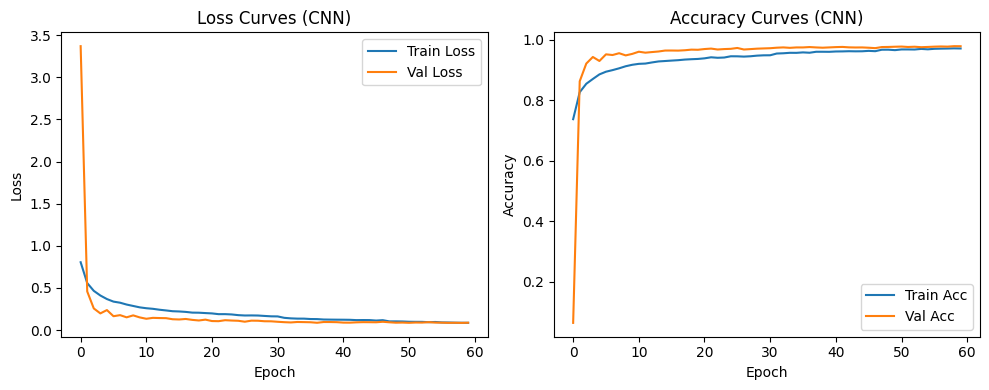

In [21]:
# Plot Training Curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves (CNN)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves (CNN)')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# Predictions
y_pred_probs = model_cnn.predict(X_test_cnn)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification Report
print("\nClassification Report (1D CNN):\n")
print(classification_report(
    y_true, y_pred,
    target_names=["N","S","V","F","Q"],
    digits=4
))

352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

Classification Report (1D CNN):

              precision    recall  f1-score   support

           N     0.9892    0.9876    0.9884      9059
           S     0.8593    0.8129    0.8355       278
           V     0.9377    0.9779    0.9573       723
           F     0.8161    0.8875    0.8503        80
           Q     0.9521    0.9444    0.9482      1115

    accuracy                         0.9777     11255
   macro avg     0.9109    0.9221    0.9160     11255
weighted avg     0.9777    0.9777    0.9777     11255



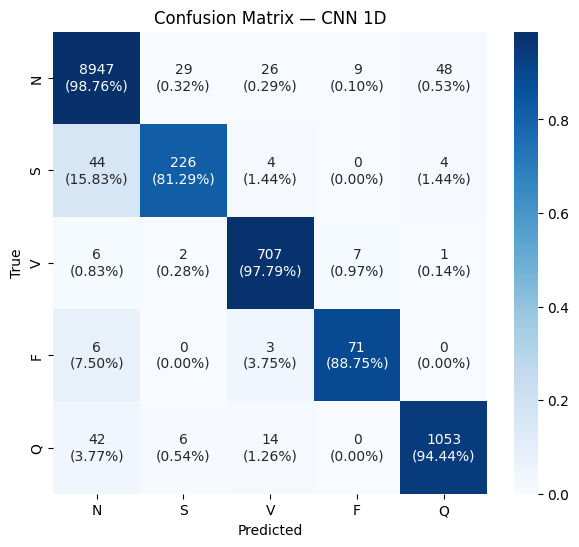

In [23]:
# Confusion matrix
cm_counts = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

labels = np.asarray([
    [f"{count}\n({percent*100:.2f}%)" for count, percent in zip(row_counts, row_norm)]
    for row_counts, row_norm in zip(cm_counts, cm_norm)
])

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=labels, fmt="", cmap="Blues",
            xticklabels=["N", "S", "V", "F", "Q"],
            yticklabels=["N", "S", "V", "F", "Q"])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — CNN 1D")
plt.show()

###**Hybrid CNN (CNN-BiLSTM)**

In [24]:
# Define Hybrid CNN–BiLSTM model
model_hybrid = Sequential([
    # Feature extraction (CNN)
    Conv1D(64, kernel_size=7, activation='relu', input_shape=(360,1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Dropout(0.3),

    # Temporal modeling (BiLSTM)
    Bidirectional(LSTM(64, return_sequences=False)),

    Dropout(0.3),

    # Classifier
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile
opt = optimizers.Adam(learning_rate=0.001)
model_hybrid.compile(
    optimizer=opt,
    loss=losses.categorical_crossentropy,
    metrics=['accuracy']
)

# Callbacks
save_dir = "/content/drive/MyDrive/Models"
os.makedirs(save_dir, exist_ok=True)
file_path = os.path.join(save_dir, "Hybrid_CNN_BiLSTM_R_peak.keras")

checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=8, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=4, factor=0.5, verbose=2)

callbacks = [checkpoint, early, reduce_lr]

model_hybrid.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)              │ (None, 354, 64)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 354, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 177, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 173, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 173, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 86, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 84, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 84, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 42, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 42, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,461 (1.23 MB)

 Trainable params: 322,565 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)

In [25]:
# Train
history_hybrid = model_hybrid.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=40,
    batch_size=128,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7071 - loss: 0.7946
Epoch 1: val_accuracy improved from -inf to 0.80487, saving model to /content/drive/MyDrive/Models/Hybrid_CNN_BiLSTM_R_peak.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.7074 - loss: 0.7939 - val_accuracy: 0.8049 - val_loss: 1.3302 - learning_rate: 0.0010
Epoch 2/40
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8996 - loss: 0.3144
Epoch 2: val_accuracy improved from 0.80487 to 0.85241, saving model to /content/drive/MyDrive/Models/Hybrid_CNN_BiLSTM_R_peak.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.8996 - loss: 0.3143 - val_accuracy: 0.8524 - val_loss: 0.4143 - learning_rate: 0.0010
Epoch 3/40
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9290 - loss: 0.2275
Epoch 3: val_accuracy improved from 0.85241 to 0.87356, saving model to /content/drive/MyDrive/Models/Hybrid_CNN_BiLSTM_R_peak.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.92

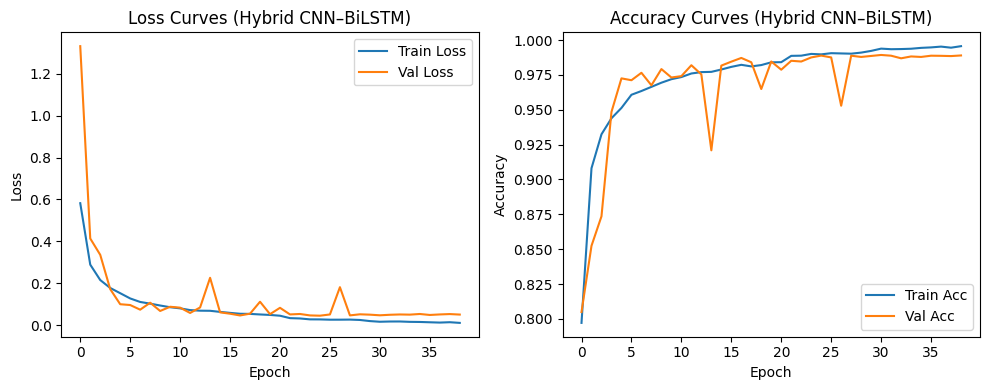

In [26]:
# Plot Training Curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_hybrid.history['loss'], label='Train Loss')
plt.plot(history_hybrid.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves (Hybrid CNN–BiLSTM)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_hybrid.history['accuracy'], label='Train Acc')
plt.plot(history_hybrid.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves (Hybrid CNN–BiLSTM)')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# Predictions
y_pred_probs = model_hybrid.predict(X_test_cnn)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification Report
print("\nClassification Report (Hybrid CNN–BiLSTM):\n")
print(classification_report(
    y_true, y_pred,
    target_names=["N","S","V","F","Q"],
    digits=4
))

352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

Classification Report (Hybrid CNN–BiLSTM):

              precision    recall  f1-score   support

           N     0.9970    0.9929    0.9950      9059
           S     0.9091    0.9353    0.9220       278
           V     0.9753    0.9834    0.9793       723
           F     0.8043    0.9250    0.8605        80
           Q     0.9831    0.9928    0.9880      1115

    accuracy                         0.9904     11255
   macro avg     0.9338    0.9659    0.9489     11255
weighted avg     0.9907    0.9904    0.9905     11255



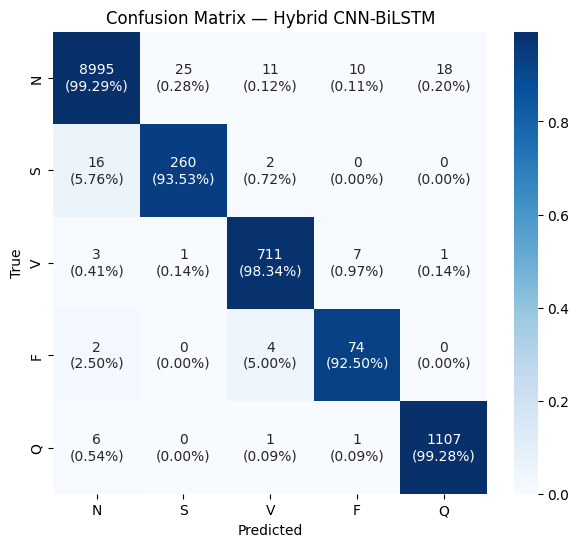

In [28]:
# Confusion matrix
cm_counts = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

labels = np.asarray([
    [f"{count}\n({percent*100:.2f}%)" for count, percent in zip(row_counts, row_norm)]
    for row_counts, row_norm in zip(cm_counts, cm_norm)
])

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=labels, fmt="", cmap="Blues",
            xticklabels=["N", "S", "V", "F", "Q"],
            yticklabels=["N", "S", "V", "F", "Q"])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Hybrid CNN-BiLSTM")
plt.show()

##**Using rolling window segments**